In [1]:
# In The Name of God - 14/12/00
# P2R Model number and g power selection
# Visualizing results
# Dataset CelebA

In [2]:
#@title
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
from collections import OrderedDict
import time

from torch.utils.data import random_split
from math import floor

import torchvision.utils as vutils
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import itertools
import random

import shutil
from zipfile import ZipFile
import os

from IPython.core.debugger import set_trace

In [3]:
!sudo apt-get update
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended texlive texlive-fonts-recommended
import os
from matplotlib.pyplot import text
matplotlib.style.use('default')
from matplotlib import rc

rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,590 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,028 kB]
Get:

In [4]:
# Hyper parameters:
# change lastRunEpochNumber for every run based on saved files

manual_seed = 20
image_size = 64
use_whole_dataset = True
usage_percent = 1.00
celeba_male_index = 20
celeba_smiling_index = 31
celeba_mouth_open_index = 21
celeba_high_cheekbone_index = 19

using_index = celeba_smiling_index
adv_using_index = celeba_male_index

batch_size = 64 #64

files_not_ready = True
dataset_folder_path = 'drive/MyDrive/myML/datasetShortcuts/CelebA'
data_dir = 'celeba'
save_dir = 'model-number-and-g-power'
saving_path = 'drive/MyDrive/myML/saves/' + save_dir + '/'

# creating modified dataset:
m_version = '-test'
on_fly_modified_dataset_saving_path = 'modifiedDatasets/' + save_dir + m_version + '/'

p2r_model_number = 0
p2r_model_path = 'drive/MyDrive/myML/saves/' + 'p2r-ae-9rev2-G-S' + '/'

utl_model_number = 6
utl_model_path = 'drive/MyDrive/ML/saves/' + 'adv-trn-2-S-NLLLoss' + '/'

adv_model_number = 9
adv_model_path = 'drive/MyDrive/ML/saves/' + 'adv-trn-2-G-NLLLoss' + '/'


use_g = True
g_eff_val = -10000
miu = 0
coef_for_var = 0

suffling_main_train_data = False
suffling_modified_train_data = False


# Other params
# Number of workers for dataloader
workers = 2
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Size of feature maps in encoder
nef = 64
# Size of feature maps in decoder
ndf = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Number of training epochs

In [5]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [6]:
# Mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:

# download dataset and unzip
# data_dir variable: data_dir = 'img_align_celeba'
dataset_zip_path = dataset_folder_path + '/Img/img_align_celeba.zip'
list_eval_partition_path = dataset_folder_path + '/Eval/list_eval_partition.txt'
identity_celeba_path = dataset_folder_path + '/Anno/identity_CelebA.txt'
list_attr_celeba_path = dataset_folder_path + '/Anno/list_attr_celeba.txt'
list_bbox_celeba_path = dataset_folder_path + '/Anno/list_bbox_celeba.txt'
list_landmarks_align_celeba_path = dataset_folder_path + '/Anno/list_landmarks_align_celeba.txt'

if files_not_ready:
    try:
      os.mkdir(data_dir)
      print("data folder created successfully")
    except OSError as e:
      print("Error: %s" % (e.strerror))

    shutil.copyfile(dataset_zip_path, data_dir + r'/img_align_celeba.zip')
    shutil.copyfile(list_eval_partition_path, data_dir + r'/list_eval_partition.txt')
    shutil.copyfile(identity_celeba_path, data_dir + r'/identity_CelebA.txt')
    shutil.copyfile(list_attr_celeba_path, data_dir + r'/list_attr_celeba.txt')
    shutil.copyfile(list_bbox_celeba_path, data_dir + r'/list_bbox_celeba.txt')
    shutil.copyfile(list_landmarks_align_celeba_path, data_dir + r'/list_landmarks_align_celeba.txt')

    try:
        shutil.rmtree(data_dir + r'/img_align_celeba')
        print("old unzipped directory removed successfully")
    except OSError as e:
        print("Error: %s" % (e.strerror))

    archive = data_dir + r'/img_align_celeba.zip'
    with ZipFile(archive, 'r') as zip:
       zip.extractall(data_dir)
try:
    os.mkdir(saving_path)
    print("saving_path directory created successfully")
except OSError as e:
    print("Error: %s" % (e.strerror))

data folder created successfully
Error: No such file or directory
Error: File exists


In [8]:
# Function - use some percent of data
def shorten_dataset(dataset, usage_percent=1.0):
  len_used = floor(len(dataset)*usage_percent)
  len_not_used = len(dataset) - len_used
  used_dataset, not_used_dataset = random_split(dataset, [len_used, len_not_used], generator=torch.Generator().manual_seed(manual_seed))
  return used_dataset

In [9]:
# Define transforms
test_transforms = transforms.Compose([transforms.Resize(image_size),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [10]:
# Load Datas
test_set = datasets.CelebA(root='', download=False, split='test', target_type=["attr", "identity"], transform=test_transforms)
# shorten Dataset
if not use_whole_dataset:
  test_set = shorten_dataset(test_set, usage_percent)
# DataLoader
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=workers, drop_last=True)

In [11]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [12]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self, ngpu):
        super(Encoder, self).__init__()
        self.ngpu = ngpu

        # input is nc x 64 x 64
        self.conv1 = nn.Conv2d(nc, nef, 4, 2, 1, bias=False)
        self.actv1 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 32 x 32
        self.conv2 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor2 = nn.BatchNorm2d(nef)
        self.actv2 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 16 x 16
        self.conv3 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor3 = nn.BatchNorm2d(nef)
        self.actv3 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 8 x 8
        self.conv4 = nn.Conv2d(nef, nef * 2, 4, 2, 1, bias=False)
        self.bnor4 = nn.BatchNorm2d(nef * 2)
        self.actv4 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef*2) x 4 x 4
        # shaping would be here: nef*2 x 4 x 4 -> 2048
        # state size. 2048
        self.fllc5 = nn.Linear(nef*2*4*4, nef*1*4*4)
        self.actv5 = nn.LeakyReLU(0.2, inplace=True)
        # state size. 1024

        # split features: 1024 -> 1022 + 2 (male/female)
        # first classifier: (gender)
        self.fllc_male_features1 = nn.Linear(nef*1*4*4, nef*1*4*4)
        self.actv_male_features1 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_male_features1 = nn.Dropout(p=0.5)
        self.fllc_male_features2 = nn.Linear(nef*1*4*4, nef*4)
        self.actv_male_features2 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_male_features2 = nn.Dropout(p=0.5)
        self.fllc_male_features3 = nn.Linear(nef*4, nef)
        self.actv_male_features3 = nn.LeakyReLU(0.2, inplace=True)
        self.fllc_male_features4 = nn.Linear(nef, 2)
        self.actv_male_features4 = nn.LogSoftmax(dim=1)
        # second classifier: (hair color)
        # self.fllc_hair_color_features1 = nn.Linear(nef*1*4*4, nef*1*4*4)
        # self.actv_hair_color_features1 = nn.LeakyReLU(0.2, inplace=True)
        # self.dropout_hair_color_features1 = nn.Dropout(p=0.5)
        # self.fllc_hair_color_features2 = nn.Linear(nef*1*4*4, nef*4)
        # self.actv_hair_color_features2 = nn.LeakyReLU(0.2, inplace=True)
        # self.dropout_hair_color_features2 = nn.Dropout(p=0.5)
        # self.fllc_hair_color_features3 = nn.Linear(nef*4, nef)
        # self.actv_hair_color_features3 = nn.LeakyReLU(0.2, inplace=True)
        # self.fllc_hair_color_features4 = nn.Linear(nef, 6)
        # self.actv_hair_color_features4 = nn.LogSoftmax(dim=1)
        # other features
        self.fllc_other_features1 = nn.Linear(nef*1*4*4, nef*1*4*4)
        self.actv_other_features1 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_other_features1 = nn.Dropout(p=0.5)
        self.fllc_other_features2 = nn.Linear(nef*1*4*4, nef*1*4*4)
        self.actv_other_features2 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_other_features2 = nn.Dropout(p=0.5)
        self.fllc_other_features3 = nn.Linear(nef*1*4*4, nef*1*4*4 - 2)
        self.actv_other_features3 = nn.LeakyReLU(0.2, inplace=True)
        # aggregate features for output

    def forward(self, x):
        # Part 1:
        x = self.conv1(x)
        x = self.actv1(x)
        x = self.conv2(x)
        x = self.bnor2(x)
        x = self.actv2(x)
        x = self.conv3(x)
        x = self.bnor3(x)
        x = self.actv3(x)
        x = self.conv4(x)
        x = self.bnor4(x)
        x = self.actv4(x)
        # flatten
        x = torch.flatten(x, start_dim = 1)
        # Part 2:
        x = self.fllc5(x)
        x = self.actv5(x)
        # first classifier: (gender)
        y1 = self.fllc_male_features1(x)
        y1 = self.actv_male_features1(y1)
        y1 = self.dropout_male_features1(y1)
        y1 = self.fllc_male_features2(y1)
        y1 = self.actv_male_features2(y1)
        y1 = self.dropout_male_features2(y1)
        y1 = self.fllc_male_features3(y1)
        y1 = self.actv_male_features3(y1)
        y1 = self.fllc_male_features4(y1)
        y1 = self.actv_male_features4(y1)
        # second classifier: (hair color)
        # y2 = self.fllc_hair_color_features1(x)
        # y2 = self.actv_hair_color_features1(y2)
        # y2 = self.dropout_hair_color_features1(y2)
        # y2 = self.fllc_hair_color_features2(y2)
        # y2 = self.actv_hair_color_features2(y2)
        # y2 = self.dropout_hair_color_features2(y2)
        # y2 = self.fllc_hair_color_features3(y2)
        # y2 = self.actv_hair_color_features3(y2)
        # y2 = self.fllc_hair_color_features4(y2)
        # y2 = self.actv_hair_color_features4(y2)
        # other features
        y3 = self.fllc_other_features1(x)
        y3 = self.actv_other_features1(y3)
        y3 = self.dropout_other_features1(y3)
        y3 = self.fllc_other_features2(y3)
        y3 = self.actv_other_features2(y3)
        y3 = self.dropout_other_features2(y3)
        y3 = self.fllc_other_features3(y3)
        y3 = self.actv_other_features3(y3)
        return y1, y3

In [13]:
# Decoder Model
class Decoder(nn.Module):
    def __init__(self, ngpu):
        super(Decoder, self).__init__()
        self.ngpu = ngpu

        # input size is 1024
        self.fllc6 = nn.Linear(nef*1*4*4, ndf*2*4*4)
        self.actv6 = nn.LeakyReLU(0.2, inplace=True)
        # state size. 2048
        # shaping would be here: 2048 -> ndf*2 x 4 x 4
        # state size. (ndf*2) x 4 x 4
        self.cnvt7 = nn.ConvTranspose2d( ndf*2, ndf, 4, 2, 1, bias=False)
        self.bnor7 = nn.BatchNorm2d(ndf)
        self.actv7 = nn.ReLU(True)
        # state size. (ndf) x 8 x 8
        self.cnvt8 = nn.ConvTranspose2d(ndf, ndf, 4, 2, 1, bias=False)
        self.bnor8 = nn.BatchNorm2d(ndf)
        self.actv8 = nn.ReLU(True)
        # state size. (ndf) x 16 x 16
        self.cnvt9 = nn.ConvTranspose2d( ndf, ndf, 4, 2, 1, bias=False)
        self.bnor9 = nn.BatchNorm2d(ndf)
        self.actv9 = nn.ReLU(True)
        # state size. (ndf) x 32 x 32
        self.cnvt10 = nn.ConvTranspose2d( ndf, nc, 4, 2, 1, bias=False)
        self.actv10 = nn.Sigmoid() # nn.Tanh()
        # state size. (nc) x 64 x 64

    def forward(self, x):
        x = self.fllc6(x)
        x = self.actv6(x)
        x = x.view(batch_size, ndf*2, 4, 4) # 64 is batch_size
        x = self.cnvt7(x)
        x = self.bnor7(x)
        x = self.actv7(x)
        x = self.cnvt8(x)
        x = self.bnor8(x)
        x = self.actv8(x)
        x = self.cnvt9(x)
        x = self.bnor9(x)
        x = self.actv9(x)
        x = self.cnvt10(x)
        x = self.actv10(x)
        return x

In [14]:
# AE Model + Noise
class AEModel(nn.Module):
    def __init__(self, ngpu, mode='train', miu=0, coef_for_var=0, g_eff_val=-10000):
        super(AEModel, self).__init__()
        self.ngpu = ngpu
        # self.change_mode(mode)
        # self.tune_noise(miu, coef_for_var)
        self.g_eff_val = g_eff_val
        self.miu = miu
        self.coef_for_var = coef_for_var
        self.mode = mode
        self.encoder = Encoder(ngpu).to(device)
        self.decoder = Decoder(ngpu).to(device)

    def tune_noise(self, miu=0, coef_for_var=0, g_eff_val=-10000):
        self.miu = miu
        self.coef_for_var = coef_for_var
        self.g_eff_val = g_eff_val

    def change_mode(self, mode='train'):
        self.mode = mode

    def add_noise(self, nodes):
      with torch.no_grad():
        var = (self.coef_for_var) * (torch.mean(nodes).item())
        noise = self.miu + (var) * torch.randn(nodes.size())
        noise = noise.to(device)
        nodes.add_(noise)
        return nodes

    def change_lbl(self, nodes, lbls):
      with torch.no_grad():
        lbls[lbls == 0] = self.g_eff_val
        lbls[lbls == 1] = 0
        nodes = lbls
        return nodes

    def forward(self, x, y1_real_lbl=[]):
        y1, y3 = self.encoder(x)
        if self.mode=='use':
            if use_g:
              # y1 = y1_real_lbl
              y1 = self.change_lbl(y1, y1_real_lbl)
            y3 = self.add_noise(y3)
        y = torch.cat((y1, y3), 1)
        x = self.decoder(y)
        return x, y1

In [15]:
# Utilizer Model
class UtlModel(nn.Module):
    def __init__(self, ngpu):
        super(UtlModel, self).__init__()
        self.ngpu = ngpu

        # input is nc x 64 x 64
        self.conv1 = nn.Conv2d(nc, nef, 4, 2, 1, bias=False)
        self.actv1 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 32 x 32
        self.conv2 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor2 = nn.BatchNorm2d(nef)
        self.actv2 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 16 x 16
        self.conv3 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor3 = nn.BatchNorm2d(nef)
        self.actv3 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 8 x 8
        self.conv4 = nn.Conv2d(nef, nef * 2, 4, 2, 1, bias=False)
        self.bnor4 = nn.BatchNorm2d(nef * 2)
        self.actv4 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef*2) x 4 x 4
        # shaping would be here: nef*2 x 4 x 4 -> 2048
        # state size. 2048
        self.fllc5 = nn.Linear(nef*2*4*4, nef*1*4*4)
        self.actv5 = nn.LeakyReLU(0.2, inplace=True)
        # state size. 1024

        # classifier:
        self.fllc_features1 = nn.Linear(nef*1*4*4, nef*1*4*4)
        self.actv_features1 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_features1 = nn.Dropout(p=0.5)
        self.fllc_features2 = nn.Linear(nef*1*4*4, nef*4)
        self.actv_features2 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_features2 = nn.Dropout(p=0.5)
        self.fllc_features3 = nn.Linear(nef*4, nef)
        self.actv_features3 = nn.LeakyReLU(0.2, inplace=True)
        self.fllc_features4 = nn.Linear(nef, 2)
        self.actv_features4 = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Part 1:
        x = self.conv1(x)
        x = self.actv1(x)
        x = self.conv2(x)
        x = self.bnor2(x)
        x = self.actv2(x)
        x = self.conv3(x)
        x = self.bnor3(x)
        x = self.actv3(x)
        x = self.conv4(x)
        x = self.bnor4(x)
        x = self.actv4(x)
        # flatten
        x = torch.flatten(x, start_dim = 1)
        # Part 2:
        x = self.fllc5(x)
        x = self.actv5(x)
        # classifier: 
        y1 = self.fllc_features1(x)
        y1 = self.actv_features1(y1)
        y1 = self.dropout_features1(y1)
        y1 = self.fllc_features2(y1)
        y1 = self.actv_features2(y1)
        y1 = self.dropout_features2(y1)
        y1 = self.fllc_features3(y1)
        y1 = self.actv_features3(y1)
        y1 = self.fllc_features4(y1)
        y1 = self.actv_features4(y1)
        return y1

In [16]:
# For Adversary
# Adversary Model 
class AdvModel(nn.Module):
    def __init__(self, ngpu):
        super(AdvModel, self).__init__()
        self.ngpu = ngpu
        
        # input is nc x 64 x 64 
        self.conv1 = nn.Conv2d(nc, nef, 4, 2, 1, bias=False)
        self.actv1 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 32 x 32
        self.conv2 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor2 = nn.BatchNorm2d(nef)
        self.actv2 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 16 x 16
        self.conv3 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor3 = nn.BatchNorm2d(nef)
        self.actv3 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 8 x 8
        self.conv4 = nn.Conv2d(nef, nef * 2, 4, 2, 1, bias=False)
        self.bnor4 = nn.BatchNorm2d(nef * 2)
        self.actv4 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef*2) x 4 x 4
        # shaping would be here: nef*2 x 4 x 4 -> 2048
        # state size. 2048
        self.fllc5 = nn.Linear(nef*2*4*4, nef*1*4*4)
        self.actv5 = nn.LeakyReLU(0.2, inplace=True)
        # state size. 1024

        # classifier: 
        self.fllc_features1 = nn.Linear(nef*1*4*4, nef*1*4*4)
        self.actv_features1 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_features1 = nn.Dropout(p=0.5)
        self.fllc_features2 = nn.Linear(nef*1*4*4, nef*4)
        self.actv_features2 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_features2 = nn.Dropout(p=0.5)
        self.fllc_features3 = nn.Linear(nef*4, nef)
        self.actv_features3 = nn.LeakyReLU(0.2, inplace=True)
        self.fllc_features4 = nn.Linear(nef, 2)
        self.actv_features4 = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Part 1:
        x = self.conv1(x)
        x = self.actv1(x)
        x = self.conv2(x)
        x = self.bnor2(x)
        x = self.actv2(x)
        x = self.conv3(x)
        x = self.bnor3(x)
        x = self.actv3(x)
        x = self.conv4(x)
        x = self.bnor4(x)
        x = self.actv4(x)
        # flatten
        x = torch.flatten(x, start_dim = 1)
        # Part 2:
        x = self.fllc5(x)
        x = self.actv5(x)
        # classifier: 
        y1 = self.fllc_features1(x)
        y1 = self.actv_features1(y1)
        y1 = self.dropout_features1(y1)
        y1 = self.fllc_features2(y1)
        y1 = self.actv_features2(y1)
        y1 = self.dropout_features2(y1)
        y1 = self.fllc_features3(y1)
        y1 = self.actv_features3(y1)
        y1 = self.fllc_features4(y1)
        y1 = self.actv_features4(y1)
        return y1

In [17]:
# Create 
netAE = AEModel(ngpu).to(device)
adversaryModel = AdvModel(ngpu).to(device)
utilizerModel = UtlModel(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netAE = nn.DataParallel(netAE, list(range(ngpu)))
    adversaryModel = nn.DataParallel(adversaryModel, list(range(ngpu)))
    utilizerModel = nn.DataParallel(utilizerModel, list(range(ngpu)))

In [18]:
#@title
# Function - Save:
def save_data(saving_path, name, res):
  checkpoint = {'res': res}
  torch.save(checkpoint, saving_path + name + '.pth')
  return True

In [19]:
def load_data(saving_path, name):
  checkpoint = torch.load(saving_path + name + '.pth', map_location=device)
  res = checkpoint['res']
  return res

In [20]:
#@title
# Function - Load:
def load_model(saving_path, name, number, model, device):

  checkpoint = torch.load(saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth', map_location=device)
  res = checkpoint['res']
  model.load_state_dict(checkpoint['state_dict'])
  return {'model':model,
          'res':res}

In [21]:
# Load Last Checkpoint:

def load_models():
  ae_load = load_model(p2r_model_path, 'ae', p2r_model_number, netAE, device)
  adv_load = load_model(adv_model_path, 'adv', adv_model_number, adversaryModel, device)
  utl_load = load_model(utl_model_path, 'adv', utl_model_number, utilizerModel, device)
  return ae_load, adv_load, utl_load

In [22]:
def extract_targets(labels):
    male_labels = labels[0][:, using_index]
    female_labels = torch.add(1, -male_labels)
    # HERE! there were a bug. we should concat(female,male) not concat(male,female)
    # gender_target = torch.cat((male_labels.view(batch_size,1), female_labels.view(batch_size,1)), 1).float() # 64 is batch_size
    gender_target = torch.cat((female_labels.view(batch_size,1), male_labels.view(batch_size,1)), 1).float() # 64 is batch_size
    gender_target = gender_target.to(device)
    return gender_target

In [23]:
m_celeba_dir = on_fly_modified_dataset_saving_path + 'celeba/'
img_celeba_dir = on_fly_modified_dataset_saving_path + 'celeba/img_align_celeba/'

In [24]:
# Create new dataset folder:
def create_modified_dataset_folder():
  try:
      os.mkdir('modifiedDatasets')
  except OSError as e:
      print("Error: %s" % (e.strerror))
  try:
      os.mkdir(on_fly_modified_dataset_saving_path)
  except OSError as e:
      print("Error: %s" % (e.strerror))
  try:
      os.mkdir(m_celeba_dir)
  except OSError as e:
      print("Error: %s" % (e.strerror))
  try:
      os.mkdir(img_celeba_dir)
  except OSError as e:
      print("Error: %s" % (e.strerror))

  try:
      shutil.copyfile(list_eval_partition_path, m_celeba_dir + r'list_eval_partition.txt')
      shutil.copyfile(identity_celeba_path, m_celeba_dir + r'identity_CelebA.txt')
      shutil.copyfile(list_attr_celeba_path, m_celeba_dir + r'list_attr_celeba.txt')
      shutil.copyfile(list_bbox_celeba_path, m_celeba_dir + r'list_bbox_celeba.txt')
      shutil.copyfile(list_landmarks_align_celeba_path, m_celeba_dir + r'list_landmarks_align_celeba.txt')
      print("label files copied successfully")
  except OSError as e:
      print("Error: %s" % (e.strerror))

In [25]:
def delete_modified_dataset_folder():
    try:
        shutil.rmtree(on_fly_modified_dataset_saving_path)
        print("old modified_dataset_folder removed successfully")
    except OSError as e:
        print("Error: %s" % (e.strerror))

In [26]:
# Function save image:
from torchvision.utils import save_image

def store_single_disk(image, file_name):
    # save as png:
    # file_name = file_name.replace('.jpg', '.png')
    save_image(image, img_celeba_dir + file_name)

In [27]:
def fix_getting_filename_problem(my_loader,i,j,batch_size):
    if use_whole_dataset:
        return my_loader.dataset.filename[i*batch_size + j]
    else:
        return my_loader.dataset.dataset.filename[i*batch_size + j]

In [28]:
def convert_dataset(my_loader):
    prog_bar = tqdm(enumerate(my_loader), total=len(my_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[1]
            inputs = inputs.to(device)
            gender_target = extract_targets(labels)
            output, y1 = netAE.forward(inputs, gender_target)
            for j in range(batch_size):
                store_single_disk(output[j,:,:,:], fix_getting_filename_problem(my_loader,i,j,batch_size))

In [29]:
# using model to convert public to reference dataset (using test dataloader)
def convert_testset():
  netAE.change_mode('use')
  netAE.eval()
  netAE.tune_noise(miu, coef_for_var, g_eff_val)
  print("\nConverting test images from public to references...")
  convert_dataset(test_loader)

In [30]:
# load modified dataset:
def created_modified_dataloader():
  m_transforms = transforms.Compose([transforms.ToTensor()])
  m_test_set = datasets.CelebA(root=on_fly_modified_dataset_saving_path, download=False, split='test', target_type=["attr", "identity"], transform=m_transforms)
  # shorten Dataset
  # if not use_whole_dataset:
  #   m_test_set = shorten_dataset(m_test_set, usage_percent)

  m_test_loader = torch.utils.data.DataLoader(m_test_set, batch_size=batch_size, num_workers=workers, drop_last=True)
  return m_test_loader

In [31]:
# Calc Accuracy
def calcAccuracy(model, test_loader, using_index):
    model.to(device)
    model.eval()
    y1_accuracy = 0
    prog_bar = tqdm(enumerate(test_loader), total=len(test_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[1]
            inputs = inputs.to(device)
            young_target = labels[0][:, using_index]
            young_target = young_target.to(device)
            output = model(inputs)
            ps_y1 = torch.exp(output)
            top_p_y1, top_class_y1 = ps_y1.topk(1, dim=1)
            equals_y1 = top_class_y1 == young_target.view(*top_class_y1.shape)
            acc_y1 = equals_y1.sum().item()
            y1_accuracy += (acc_y1 / len(equals_y1))            
    y1_accuracy = y1_accuracy / len(test_loader)
    return y1_accuracy

In [32]:
# Test on obfuscated data
def test_on_obfuscated_data(model, loader, index):
  model.to(device)
  acc = calcAccuracy(model, loader, index)
  return acc

In [33]:
# Search for best p2r model number - just check one value

# use_g = False
# g_eff_val = -1
# miu = 0
# coef_for_var = 0
# p2r_model_number = 4
# ae_load, adv_load, utl_load = load_models()
# delete_modified_dataset_folder()
# create_modified_dataset_folder()
# convert_testset()
# m_test_loader = created_modified_dataloader()
# adv_accuracy = test_on_obfuscated_data(adversaryModel, m_test_loader, adv_using_index)
# print(f"\n Adversary Accuracy on Testset: {adv_accuracy:.6f}")
# utilizerModel.to(device)
# utl_accuracy = test_on_obfuscated_data(utilizerModel, m_test_loader, using_index)
# print(f"\n Adversary Accuracy on Testset: {utl_accuracy:.6f}")

In [34]:
# Search for best p2r model number - loop (all values)

load_saved_data = True
last_saved_number = 200

save_every_i = 5
whole_epochs = 200
if load_saved_data:
  whole_epochs = 200 - last_saved_number
p2r_epoch_range = range(whole_epochs)
# g_power_indices = [-1, -10, -100, -1000, -10000, -100000]
# use_g_range = [False, True]

use_g = False
g_eff_val = -1
miu = 0
coef_for_var = 0

adv_acc=[]
utl_acc=[]

if load_saved_data:
  res = load_data(saving_path, 'rev2-GS-UP-nog-nonoise-' + str(last_saved_number))
  adv_acc = res['adv_acc']
  utl_acc = res['utl_acc']
  
if not load_saved_data:
  for i in p2r_epoch_range:
    if load_saved_data:
      i = i + (last_saved_number+1) 
    print(f"Epoch {i}/{whole_epochs}: ")
    p2r_model_number = i
    ae_load, adv_load, utl_load = load_models()
    delete_modified_dataset_folder()
    create_modified_dataset_folder()
    convert_testset()
    m_test_loader = created_modified_dataloader()
    adv_accuracy = test_on_obfuscated_data(adversaryModel, m_test_loader, adv_using_index)
    adv_acc.append(adv_accuracy)
    utilizerModel.to(device)
    utl_accuracy = test_on_obfuscated_data(utilizerModel, m_test_loader, using_index)
    utl_acc.append(utl_accuracy)
    print(f"\n Adversary Accuracy on Testset: {adv_accuracy:.6f}")
    print(f"\n Utilizer Accuracy on Testset: {utl_accuracy:.6f}")
    if i % save_every_i == 0:
      res = {'adv_acc': adv_acc,'utl_acc': utl_acc };
      save_data(saving_path, 'rev2-GS-UP-nog-nonoise-' + str(i), res)

In [35]:
# Some bullshit for fake data creation between 80 and 140 epochs!

# adv_raw = np.linspace(adv_acc[80],adv_acc[140],61)
# adv_raw = torch.from_numpy(adv_raw)
# adv_noise = 0.0035 * torch.randn(adv_raw.shape)
# adv_noise = adv_noise.to(device)
# adv_raw = adv_raw.to(device)
# adv_raw.add_(adv_noise)
# adv_noisy_temp = adv_raw.tolist()
# adv_noisy = adv_noisy_temp[1:60]

# utl_raw = np.linspace(utl_acc[80],utl_acc[140],61)
# utl_raw = torch.from_numpy(utl_raw)
# utl_noise = 0.0035 * torch.randn(utl_raw.shape)
# utl_noise = utl_noise.to(device)
# utl_raw = utl_raw.to(device)
# utl_raw.add_(utl_noise)
# utl_noisy_temp = utl_raw.tolist()
# utl_noisy = utl_noisy_temp[1:60]

# from itertools import repeat

# last_saved_number_p1 = 80
# res_p1 = load_data(saving_path, 'rev2-GS-UP-nog-nonoise-' + str(last_saved_number_p1))
# adv_acc_p1 = res_p1['adv_acc']
# utl_acc_p1 = res_p1['utl_acc']

# last_saved_number_p2 = 200
# res_p2 = load_data(saving_path, 'rev2-GS-UP-nog-nonoise-' + str(last_saved_number_p2))
# adv_acc_p2 = res_p2['adv_acc']
# utl_acc_p2 = res_p2['utl_acc']

# adv_acc_m = adv_noisy
# utl_acc_m = utl_noisy

# adv_acc = adv_acc_p1 + adv_acc_m + adv_acc_p2
# utl_acc = utl_acc_p1 + utl_acc_m + utl_acc_p2

# res = {'adv_acc': adv_acc,'utl_acc': utl_acc };
# save_data(saving_path, 'rev2-GS-UP-nog-nonoise-' + str(200), res)

UP plot...


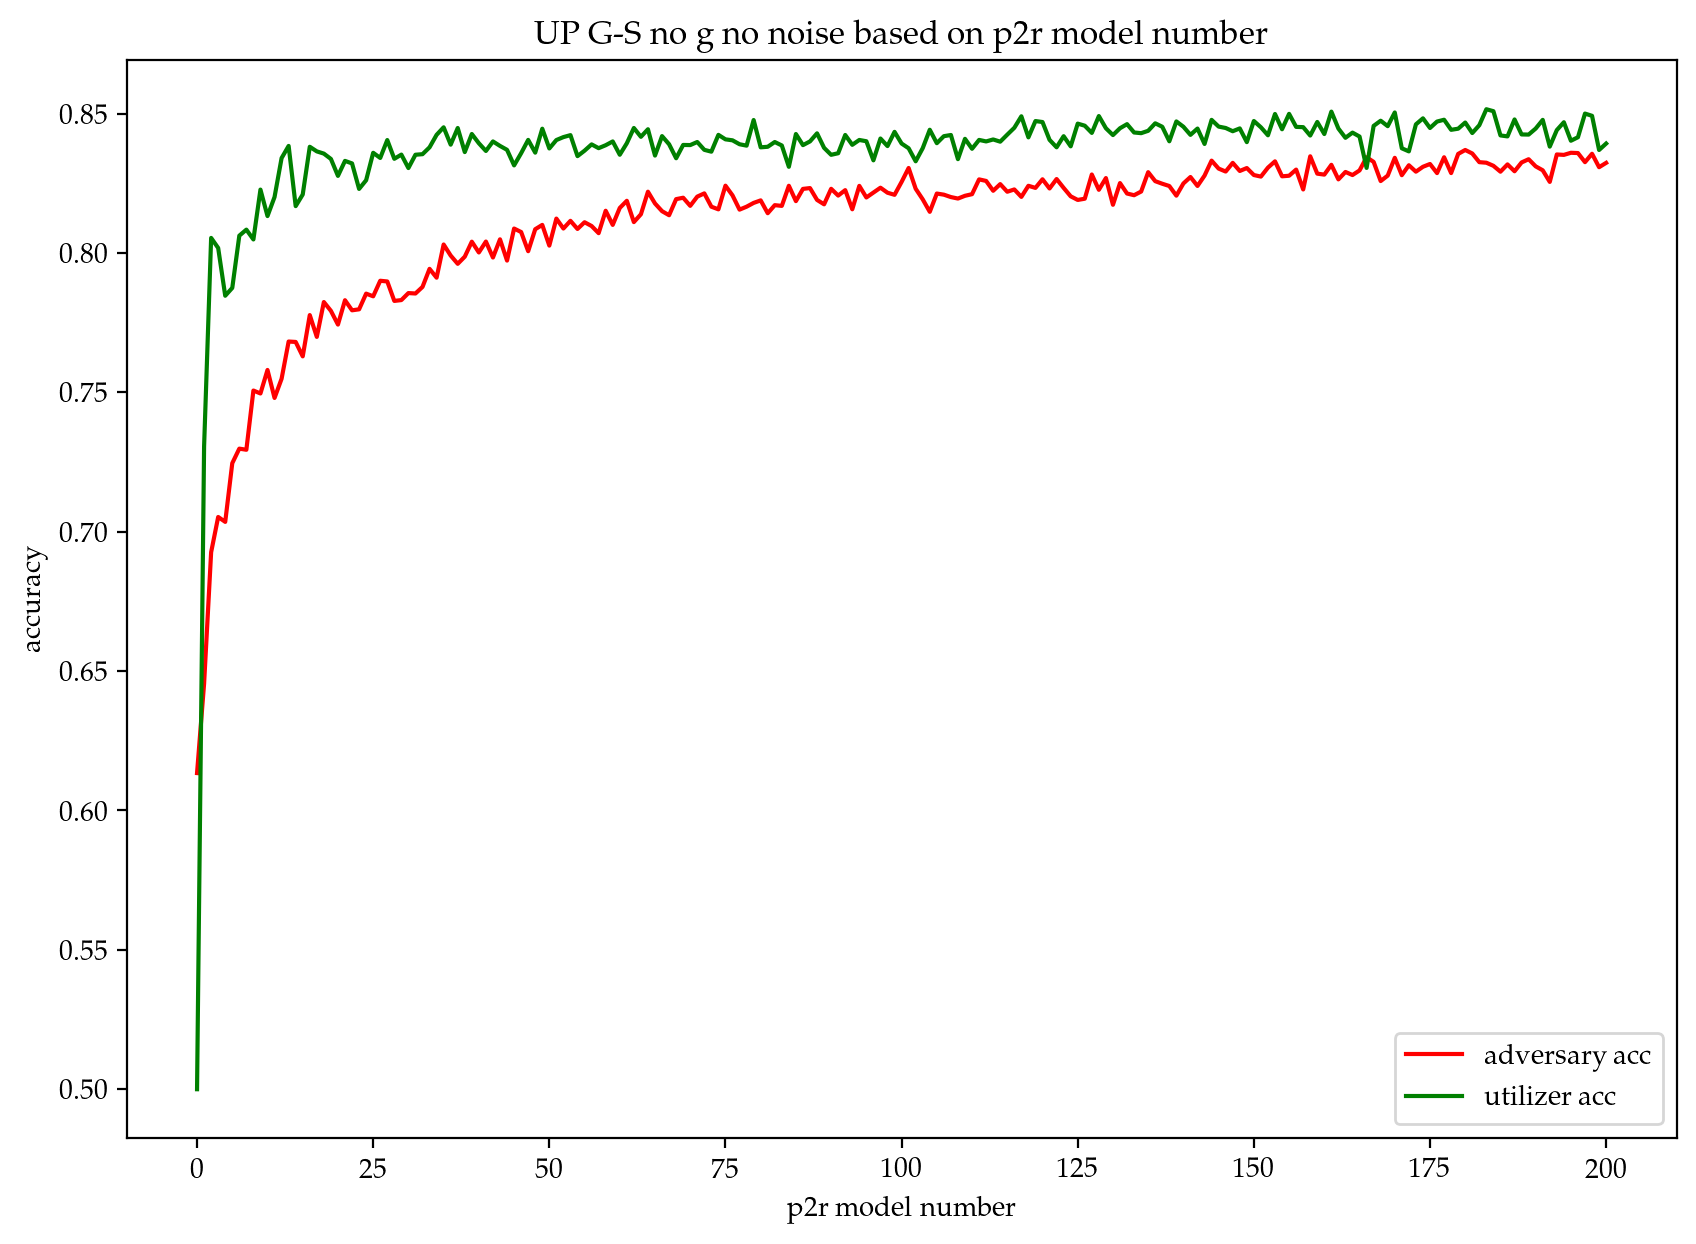

In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print('UP plot...')

plt.figure(figsize=(10,7))
plt.title("UP G-S no g no noise based on p2r model number")
plt.plot(adv_acc, color='red', label='adversary acc')
plt.plot(utl_acc, color='green', label='utilizer acc')
plt.xlabel("p2r model number")
plt.ylabel("accuracy")
plt.legend()
plt.savefig(saving_path + "up_gs_nog_nonoise_vs_p2r_modelnumber_plot.png")
plt.show()

Select p2r model number plot...


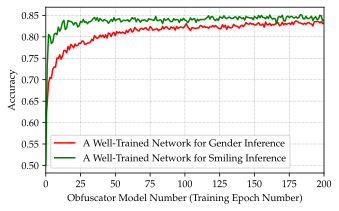

In [45]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.style.use('default')
matplotlib.style.use('default')
from matplotlib import rc

rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

print('Select p2r model number plot...')

fig = plt.figure(figsize=(5,3))
matplotlib.rcParams.update({'font.size': 10})
fig.tight_layout()
# plt.title("model number selection for CelebA-G-S without f & g")
plt.plot(adv_acc, color='red', label='A Well-Trained Network for Gender Inference')
plt.plot(utl_acc, color='green', label='A Well-Trained Network for Smiling Inference')
plt.xlabel("Obfuscator Model Number (Training Epoch Number)")
plt.ylabel("Accuracy")
plt.xlim([0,200])
plt.legend()
plt.grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)
plt.savefig(saving_path + "p2rNumber_selection_gs_plot.svg", bbox_inches = 'tight')
plt.savefig(saving_path + "p2rNumber_selection_gs_plot.png", bbox_inches = 'tight')
plt.savefig(saving_path + "p2rNumber_selection_gs_plot.eps", bbox_inches = 'tight', format='eps')
plt.show()

In [46]:
# For choosing best models: from big epochs
import operator
indexed = list(enumerate(utl_acc))
top_30 = sorted(indexed, key=operator.itemgetter(1))[-30:]
index_list = list(reversed([i for i, v in top_30]))
print(index_list)
utl_list = list(reversed([v for i, v in top_30]))
print(utl_list)
adv_list = [adv_acc[i] for i in index_list]
print(adv_list)

[183, 184, 161, 170, 197, 155, 153, 198, 128, 117, 174, 187, 177, 191, 144, 79, 168, 150, 119, 139, 176, 159, 120, 194, 180, 136, 125, 132, 173, 182]
[0.8515373794212219, 0.8508340032154341, 0.8506832797427653, 0.8503818327974276, 0.8499799035369775, 0.849879421221865, 0.8498291800643086, 0.8491760450160771, 0.8490874558866887, 0.8490069299496088, 0.8482717041800643, 0.8478697749196141, 0.8477692926045016, 0.8477190514469454, 0.8477190514469454, 0.8476688102893891, 0.8474176045016077, 0.8473171221864951, 0.847300564507292, 0.8471630010156446, 0.8471161575562701, 0.8469654340836013, 0.8469441988403607, 0.8468649517684887, 0.8467644694533762, 0.8464899548324921, 0.84637057435043, 0.8461837599607233, 0.8461113344051447, 0.8458098874598071]
[0.8323452572347267, 0.8312399517684887, 0.8315916398713826, 0.8341036977491961, 0.8325462218649518, 0.8276728295819936, 0.8328476688102894, 0.835560691318328, 0.8226309201810389, 0.8200838930445692, 0.8308882636655949, 0.8292805466237942, 0.83430466237

In [39]:
# For choosing best models: from small epochs
import operator
indexed = list(enumerate(utl_acc[:15]))
top_30 = sorted(indexed, key=operator.itemgetter(1))[-5:]
index_list = list(reversed([i for i, v in top_30]))
print(index_list)
utl_list = list(reversed([v for i, v in top_30]))
print(utl_list)
adv_list = [adv_acc[i] for i in index_list]
print(adv_list)

[13, 12, 9, 11, 14]
[0.8383741961414791, 0.8340032154340836, 0.8226989549839229, 0.8200361736334405, 0.816770498392283]
[0.7681872990353698, 0.7548231511254019, 0.7495478295819936, 0.7479401125401929, 0.768036575562701]


In [62]:
# Search for best g power (g_eff_value)
load_saved_data = True
g_eff_vals = [-1, -500, -1000, -2000, -3000, -4000, -5000, -10000]

use_g = True
miu = 0
coef_for_var = 0
p2r_model_number = 13  # 183 or 13
adv_acc_p2rnum1 = []
utl_acc_p2rnum1 = []

if load_saved_data:
  res_p2rnum1 = load_data(saving_path, 'rev2-GS-UP-p2r13-nonoise') # 183 -> 13
  adv_acc_p2rnum1 = res_p2rnum1['adv_acc']
  utl_acc_p2rnum1 = res_p2rnum1['utl_acc']
else:  
  for g_eff_val in g_eff_vals:
    ae_load, adv_load, utl_load = load_models()
    delete_modified_dataset_folder()
    create_modified_dataset_folder()
    convert_testset()
    m_test_loader = created_modified_dataloader()
    adv_accuracy = test_on_obfuscated_data(adversaryModel, m_test_loader, adv_using_index)
    utilizerModel.to(device)
    utl_accuracy = test_on_obfuscated_data(utilizerModel, m_test_loader, using_index)
    adv_acc_p2rnum1.append(adv_accuracy)
    utl_acc_p2rnum1.append(utl_accuracy)
    print(f"\n Adversary Accuracy on Testset: {adv_accuracy:.6f}")
    print(f"\n Utilizer Accuracy on Testset: {utl_accuracy:.6f}")
  res_p2rnum1 = {'adv_acc': adv_acc_p2rnum1,'utl_acc': utl_acc_p2rnum1 };
  save_data(saving_path, 'rev2-GS-UP-p2r13-nonoise', res_p2rnum1) # 183 -> 13

# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# print('UP plot...')

# plt.figure(figsize=(10,7))
# plt.title("UP G-S p2r183 nonoise based on g power") # 183 -> 13
# plt.plot(g_eff_vals, adv_acc_p2rnum1, color='red', label='adversary acc')
# plt.plot(g_eff_vals, utl_acc_p2rnum1, color='green', label='utilizer acc')
# plt.xlabel("g power")
# plt.ylabel("accuracy")
# plt.legend()
# plt.savefig(saving_path + "up_gs_p2r183_nonoise_vs_g_power_plot.png") # 183 -> 13
# plt.show()

In [63]:
matplotlib.style.use('default')
from matplotlib import rc

rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

Select lambda plot...


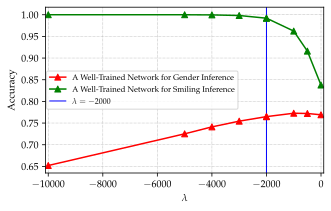

In [65]:
%matplotlib inline

matplotlib.style.use('default')
matplotlib.style.use('default')
from matplotlib import rc

rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
print('Select lambda plot...')

fig = plt.figure(figsize=(5,3))
matplotlib.rcParams.update({'font.size': 10})
fig.tight_layout()
# plt.title("lambda selection for model number 13") # 183 -> 13
plt.plot(g_eff_vals, adv_acc_p2rnum1, color='red', label='A Well-Trained Network for Gender Inference', marker='^')
plt.plot(g_eff_vals, utl_acc_p2rnum1, color='green', label='A Well-Trained Network for Smiling Inference', marker='^')
plt.axvline(x=-2000, linewidth=1, color='blue', label='$\lambda=-2000$') # -3000 or -2000
plt.plot([-2000], adv_acc_p2rnum1[3], color='red', marker='^') # -3000 or -2000 / 3 or 4
plt.plot([-2000], utl_acc_p2rnum1[3], color='green', marker='^') # -3000 or -2000 / 3 or 4
plt.xlabel(r'$\lambda$')
plt.ylabel("Accuracy")
plt.xlim([-10100,+100])
plt.legend(fontsize=8, loc=5, bbox_to_anchor=(0.706,0.5))
plt.grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)
plt.savefig(saving_path + "g_selection_gs13_plot.svg", bbox_inches = 'tight') # 183 -> 13
plt.savefig(saving_path + "g_selection_gs13_plot.png", bbox_inches = 'tight') # 183 -> 13
plt.savefig(saving_path + "g_selection_gs13_plot.eps", bbox_inches = 'tight', format='eps') # 183 -> 13
plt.show()

In [43]:
# Search for best noise var
load_saved_data = False
coef_for_vars = [0, 1, 5, 10, 15, 20, 25]
p2r_model_number = 183  # 13
g_eff_val = -10000 # 

use_g = True
miu = 0
adv_acc_noisy = []
utl_acc_noisy = []

if load_saved_data:
  res_noisy = load_data(saving_path, 'rev2-GS-UP-p2r183-g10000') # 183 -> 13
  adv_acc_noisy = res_noisy['adv_acc']
  utl_acc_noisy = res_noisy['utl_acc']
else:  
  for coef_for_var in coef_for_vars:
    ae_load, adv_load, utl_load = load_models()
    delete_modified_dataset_folder()
    create_modified_dataset_folder()
    convert_testset()
    m_test_loader = created_modified_dataloader()
    adv_accuracy = test_on_obfuscated_data(adversaryModel, m_test_loader, adv_using_index)
    utilizerModel.to(device)
    utl_accuracy = test_on_obfuscated_data(utilizerModel, m_test_loader, using_index)
    adv_acc_noisy.append(adv_accuracy)
    utl_acc_noisy.append(utl_accuracy)
    print(f"\n Adversary Accuracy on Testset: {adv_accuracy:.6f}")
    print(f"\n Utilizer Accuracy on Testset: {utl_accuracy:.6f}")
  res_noisy = {'adv_acc': adv_acc_noisy,'utl_acc': utl_acc_noisy };
  save_data(saving_path, 'rev2-GS-UP-p2r183-g10000', res_noisy) # 183 -> 13

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print('UP plot...')

plt.figure(figsize=(10,7))
plt.title("UP G-S p2r183 g10000 based on noise var") # 183 -> 13
plt.plot(coef_for_vars, adv_acc_noisy, color='red', label='adversary acc')
plt.plot(coef_for_vars, utl_acc_noisy, color='green', label='utilizer acc')
plt.xlabel("noise var")
plt.ylabel("accuracy")
plt.legend()
plt.savefig(saving_path + "up_gs_p2r183_g10000_vs_noise_var_plot.png") # 183 -> 13
plt.show()

Error: No such file or directory
label files copied successfully

Converting test images from public to references...


100%|██████████| 311/311 [00:46<00:00,  6.75it/s]



 Adversary Accuracy on Testset: 0.783511

 Utilizer Accuracy on Testset: 1.000000
old modified_dataset_folder removed successfully
Error: File exists
label files copied successfully

Converting test images from public to references...


 82%|████████▏ | 256/311 [01:59<00:25,  2.14it/s]


KeyboardInterrupt: ignored

In [ ]:
# test code for visualization:
# first_batch = next(iter(test_loader))
# inputs, labels = first_batch[0], first_batch[1]
# inputs = inputs.to(device)
# gender_target = extract_targets(labels)
# print(gender_target.to(device)[:8])
# netAE.change_mode('use')
# do_reverse = False
# # netAE.tune_noise(miu=0, coef_for_var=0, g_eff_val=-100)
# if do_reverse:
#   gender_target[gender_target == 0] = 1
#   gender_target[gender_target == 1] = 0
# output, y1 = netAE.forward(inputs, gender_target)

# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Images")
# plt.imshow(np.transpose(vutils.make_grid(output.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
# print(y1.to(device)[:8])

In [ ]:
# first_batch = next(iter(test_loader))
# plt.figure(figsize=(2,2))
# plt.axis("off")
# plt.title("Images")
# plt.imshow(np.transpose(vutils.make_grid(first_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# m_first_batch = next(iter(m_test_loader))
# plt.figure(figsize=(2,2))
# plt.axis("off")
# plt.title("Images")
# plt.imshow(np.transpose(vutils.make_grid(m_first_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# first_batch1 = next(iter(test_loader))
# first_batch2 = next(iter(m_test_loader))

# first_batch1[0][0] = first_batch1[0][5]
# first_batch1[0][1] = first_batch1[0][16]
# first_batch1[0][2] = first_batch1[0][18]
# first_batch1[0][3] = first_batch1[0][21]
# first_batch1[0][4] = first_batch1[0][29]
# first_batch1[0][5] = first_batch1[0][43]
# first_batch1[0][6] = first_batch1[0][44]
# first_batch1[0][7] = first_batch1[0][54]

# first_batch2[0][0] = first_batch2[0][5]
# first_batch2[0][1] = first_batch2[0][16]
# first_batch2[0][2] = first_batch2[0][18]
# first_batch2[0][3] = first_batch2[0][21]
# first_batch2[0][4] = first_batch2[0][29]
# first_batch2[0][5] = first_batch2[0][43]
# first_batch2[0][6] = first_batch2[0][44]
# first_batch2[0][7] = first_batch2[0][54]

# plt.figure(figsize=(16,16))
# plt.axis("off")
# plt.imshow(np.transpose(vutils.make_grid(first_batch1[0][0:8].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
# # plt.savefig(saving_path + "main_pics.png")
# plt.figure(figsize=(16,16))
# plt.axis("off")
# plt.imshow(np.transpose(vutils.make_grid(first_batch2[0][0:8].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
# plt.savefig(saving_path + "obf_f0_nog_pics.png")